In [1]:
import numpy as np
from math import pi as Pi
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
import random

## Computing the Gradient of a Loss Function

### OLS Regression

Recall our example model of simple OLS regression. Let's create a dataset of this nature and then fit our model using gradient descent.

In [2]:
x = 2*np.random.randn(50)
y = 4*x -2 + 3*np.random.randn(len(x))

Text(0.5, 0, 'X')

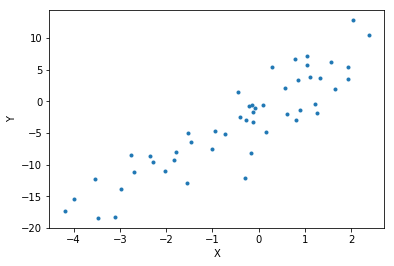

In [3]:
plt.plot(x,y, '.')
plt.ylabel("Y")
plt.xlabel("X")

First, let's use the analytical solution and verify that we can recover the correct regression coefficients.

In [4]:
X = np.transpose(np.array([np.ones(len(x)), x]))

In [5]:
np.matmul(np.matmul(np.linalg.inv( np.matmul(np.transpose(X) , X)), np.transpose(X)), y.reshape(len(x),1))

array([[-1.58608146],
       [ 3.92955816]])

Next, we'll use gradient descent to estimate the model coefficients. This is exactly the same process we've use before with finding the minima of other functions. This time, we'll compute the gradient as we derived in the lecture notes.

In [6]:
def loss(y, y_hat):
    # Root Mean Squared loss metric
    return np.sqrt(np.average((y-y_hat)**2))

def ols_yhat(x,y,coeffs):
    # returns model prediction for simple OLS regressor
    beta_0, beta_1 = coeffs
    return beta_0 + beta_1 * x

In [7]:
def grad_descent(x, y, starting_point=None, iterations=10, learning_rate=1e-1):
    """
    Estimate the coefficients of simple regression model using gradient descent.
    model: y = beta_0 + beta_1*X
    
    Args
        x (np.array) 
        y (np.array)
        starting_point (tuple2) initialization point for gradient descent
        iterations (int) number of iterations before stopping
        learning_rate (float) 
        
    
    Returns
        (np.array) trajectory through parameter space towards minimum
        (np.array) total loss metric throughout gradient descent iterations
    """
    if starting_point:
        point = starting_point
    else:
        point = np.random.uniform(-10,10,size=2)
    trajectory = [point]
    losses = [loss(y, ols_yhat(x,y,point))]
    
    for i in range(iterations):
        grad = grad_f(point, x, y)
        point = point - learning_rate * grad
        trajectory.append(point)
        losses.append(loss(y, ols_yhat(x,y,point)))
    return (np.array(trajectory), losses)

In [8]:
def grad_f(vector, x, y):
    """
    Computes local gradient vector for squared-error loss on OLS regression model cofficients
    """
    beta_0, beta_1 = vector
    y_hat = ols_yhat(x, y, vector) 
    residuals = (y - y_hat)

    dL_dbeta_0 =  - 2*np.average(residuals)
    dL_dbeta_1 =  - 2*np.average(residuals*x)
    
    return np.array([dL_dbeta_0, dL_dbeta_1])

In [9]:
#np.random.seed(10)
traj, losses = grad_descent(x, y, iterations=20,learning_rate=1e-1)

Text(0, 0.5, 'beta_1')

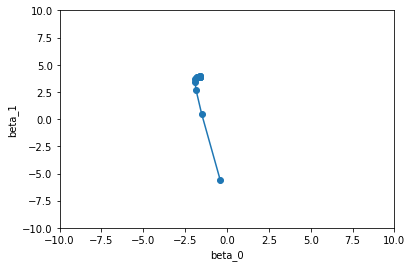

In [10]:
x= traj[:,0]
y= traj[:,1]
plt.plot(x,y,'-o')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.xlabel("beta_0")
plt.ylabel("beta_1")

Text(0.5, 0, 'Iteration')

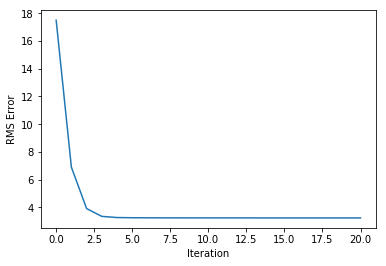

In [11]:
plt.plot(losses)
plt.ylabel("RMS Error")
plt.xlabel("Iteration")

Note that optimizing this function was extremely similar to what we've done before. We simply need to iteratively compute the gradient vector, and then walk in the opposite direction of that gradient vector, and we will walk toward the minimum of the Loss surface. 

The differences are:
1.   We don't have an expression for the total Loss surface (well, we *could* because it is simple OLS regression, but let's ignore that). Instead, we walk "blindly" down the hill until our algorithms terminates.
2. Our expression for the gradient vector - it look us a little bit of algebra to get there, but it is still simple enough to compute at each iteration.

### Simple Neural Network - Regression

Now let's turn to a more interesting example. Again, all the components are similar to above and the only difference is the algebra and calculus that leads us to our gradient calculation. We're going to create a network for non-linear regression, so let's create some synthetic noisy data drawn from an unknown continuous curve.

In [12]:
np.random.seed(1)
x = np.sort(np.random.uniform(-5,5,20))
y = .5 * (-np.sin((Pi * (x))/6) + 1+ .1*np.random.randn(len(x)))

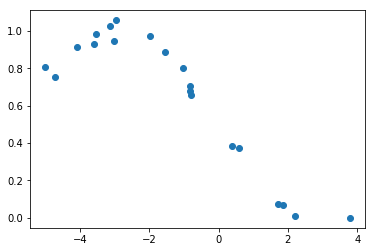

In [13]:
plt.plot(x,y, 'o')

In [21]:

def loss(y, y_hat):
    # Root Mean Squared loss metric
    return np.sqrt(np.average((y-y_hat)**2))

def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1-sigmoid(x))

def yhat(x, y, coeffs):
    # returns model prediction 
    w1, w2, w3, w4, b = coeffs
    return w3*sigmoid(w1*x) + w4*sigmoid(w2*x) + b



In [17]:
X = np.array([1,2,3])

np.testing.assert_almost_equal(
    sigmoid_derivative(X),
    np.array([0.2, 0.1, 0.04]),
    decimal=1)


np.testing.assert_almost_equal(
    yhat(X, np.array([1,1,1,1,1])),
    np.array([2.4, 2.7, 2.9]),
    decimal=1)

np.testing.assert_almost_equal(
    yhat(X, np.array([-1,-1,-1,-1,-1])),
    np.array([-1.5, -1.2, -1.09]),
    decimal=1)


TypeError: yhat() missing 1 required positional argument: 'coeffs'

In [23]:
def grad_f(vector, x, y):
    """
    Computes local gradient vector for squared-error loss on model parameters
    """
    w1, w2, w3, w4, b = vector
    prediction = yhat(x, y, vector)
    residuals = (y - prediction)
    
    dL_dw1 = - np.average(x*residuals*w3*sigmoid_derivative(w1*x))
    dL_dw2 = - np.average(x*residuals*w4*sigmoid_derivative(w2*x))
    dL_dw3 = - np.average(sigmoid(w1*x) * residuals)
    dL_dw4 = - np.average(sigmoid(w2*x) * residuals)
    dL_db = - np.average(residuals)
   
    
    return np.array([dL_dw1, dL_dw2, dL_dw3, dL_dw4, dL_db])

In [24]:
def grad_descent(x, y, starting_point=None, iterations=10, learning_rate=1e-2):
    if starting_point:
        point = starting_point
    else:
        point = np.random.uniform(-1,1,size=5).astype("float128")
    trajectory = [point]
    losses = [loss(y, yhat(x,y,point))]
    
    for i in range(iterations):
        grad = grad_f(point, x, y)
        point = point - learning_rate * grad
        trajectory.append(point)
        losses.append(loss(y, yhat(x,y,point)))
    return (np.array(trajectory), losses)

In [28]:
traj, losses = grad_descent(x, y, iterations=500,learning_rate=1e-1)

Text(0.5, 0, 'Iteration')

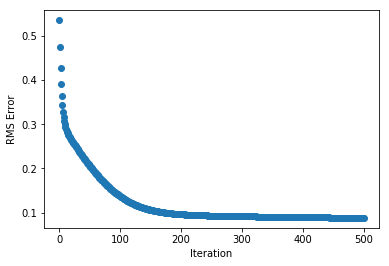

In [29]:
plt.plot(losses,'o')
plt.ylabel("RMS Error")
plt.xlabel("Iteration")

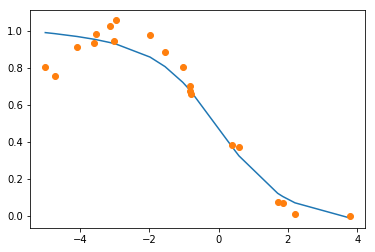

In [30]:
plt.plot(x, yhat(x,y,traj[-1]),'-')
plt.plot(x,y, 'o')

## Exercise - Classification

We're going to code a binary classifier for 2D input data. 

Consider the network shown in Figure 6.2 in Goodfellow. If we include all bias terms, this network will have 9 free parameters.

1. Derive the update rules (gradient) for each of the weights and biases for the network in Figure 6.2. Use sigmoid activation units (or ReLU units if you'd prefer). You can either derive each partial derivtive individually, or rely on the generic forumla we discussed.

2. Write a new function grad_f() for this kind of network.

3. Verify that you can fit the simple Gaussian dataset below, make a plot of the Loss throughout training. 

#### Gaussians Dataset

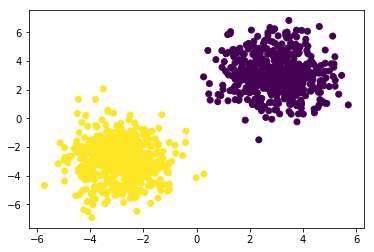

In [ ]:
x = np.concatenate(
    (np.random.multivariate_normal(mean=[-3,-3],cov=[[1,0],[0,2]],size = 500),
    np.random.multivariate_normal(mean=[3,3],cov=[[1,0],[0,2]],size = 500)))
y = np.zeros(1000)
y[:500] = 1
plt.scatter(x[:,0], x[:,1], c=y)